In [36]:
# 2017-11-22 deep learning club
# digits regognition (cifar10) + data augmentation 
# concepts covered: 
# - [x] NN with dense layers
# - [x] not so deep cNN
# - [x] weights initialization
# - data augmentation
# - [x] saving and loading the model

In [120]:
from __future__ import print_function
import keras
from keras.datasets import cifar10, mnist
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.models import load_model

# convenient imports
import tensorflow as tf
from keras import backend as K

In [147]:
import sys,os,time,random
import numpy as np

import matplotlib
matplotlib.use('Agg');
import matplotlib.pyplot as plt
plt.set_cmap('gray');

import tensorflow as tf

import skimage
from skimage.io import imread, imsave
import pickle
import scipy

from scipy import stats

from os import walk
%matplotlib inline

/Users/kkolyva/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [39]:
print("keras", keras.__version__)
print("tensorflow", tf.__version__)

keras 2.0.8
tensorflow 1.0.0


In [40]:
# check the backend the ordering of the channels
print(keras.backend.backend())
print(keras.backend.image_dim_ordering())
print(K.image_data_format())

tensorflow
tf
channels_last


In [137]:
#reproducibility
answer_to_all_questions = seed = 1331
random.seed(answer_to_all_questions)
np.random.seed(answer_to_all_questions)
tf.set_random_seed(answer_to_all_questions)

In [42]:
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')[:,:,:, None]
x_test = x_test.astype('float32')[:,:,:, None]

x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


In [43]:
# normalization
x_train /= 255
x_test /= 255

In [44]:
batch_size = 128
epochs = 10
num_classes = 10

num_channels = 1

input_shape = (x_train.shape[1], x_train.shape[2], num_channels)

print ("input shape:", input_shape)

input shape: (28, 28, 1)


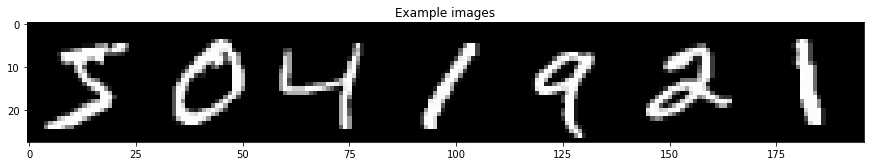

In [45]:
# put the show images here 
# examples of the images from the training set 
n_images_show = 7
plt.rcParams['figure.figsize'] = (15, 5)
plt.title("Example images")
plt.imshow(np.concatenate(x_train[:n_images_show, :, :, 0],axis=1), interpolation='none');

In [46]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [47]:
# fully connected model
def create_dense_model(initializer):
    model = Sequential()
    model.add(Flatten(input_shape=x_train.shape[1:]))
    model.add(Dense(100, kernel_initializer=initializer))
    model.add(keras.layers.normalization.BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(num_classes, kernel_initializer=initializer))

    # initiate RMSprop optimizer
    opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

In [48]:
initializers = ['zeros', 'ones', 'random_uniform', 'glorot_uniform']
model = create_dense_model(initializers[0])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               78500     
_________________________________________________________________
batch_normalization_3 (Batch (None, 100)               400       
_________________________________________________________________
activation_12 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1010      
Total params: 79,910
Trainable params: 79,710
Non-trainable params: 200
_________________________________________________________________


In [49]:
history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s - loss: 1.1921e-07 - acc: 0.0987 - val_loss: 1.1921e-07 - val_acc: 0.0980

Available data: dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


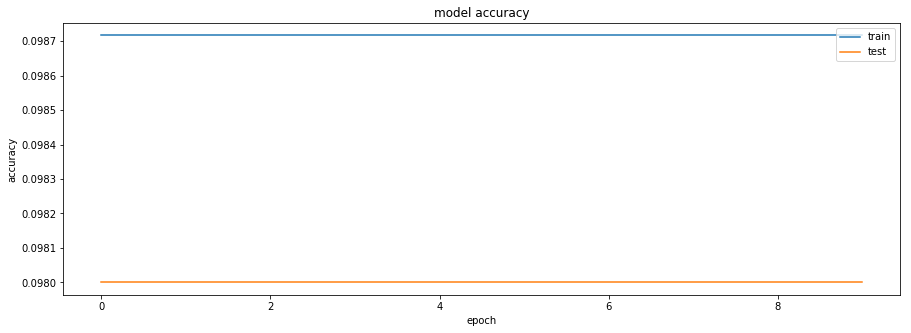

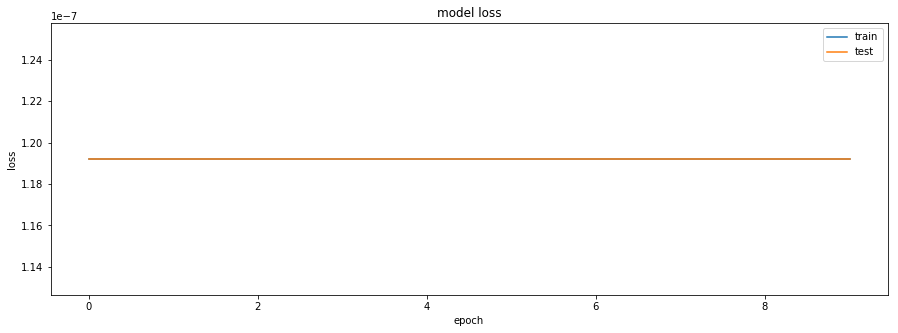

In [51]:
print("Available data:", history.history.keys())
# summarize history for accuracy
plt.figure
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

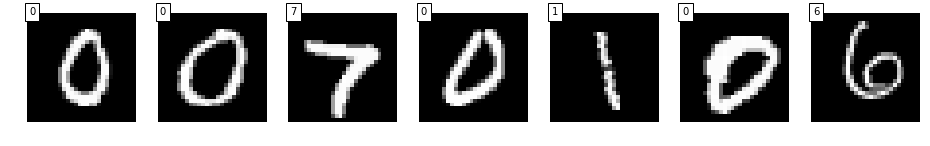

In [149]:
# put the show images here 
# examples of the images from the training set 
n_images_show = 7
# plt.rcParams['figure.figsize'] = (15, 5)
# plt.title("Example images")
sample = x_test[np.random.choice(x_test.shape[0], n_images_show, replace=False)]

predicted = model.predict(sample).argmax(-1)
plt.figure(figsize=(16,8))
for i in range(n_images_show):
    plt.subplot(1, n_images_show, i+1)
    plt.imshow(sample[i, :, :, 0], interpolation='none',)
    plt.text(0, 0, predicted[i], color='black', 
             bbox=dict(facecolor='white', alpha=1))
    plt.axis('off')


# for j in range (0,n_images_show):
#     textstr = j
#     props = dict(facecolor='white', alpha=1)
#     # place a text box in upper left in axes coords
#     ax.text(0.01+j*0.14, 0.95, textstr, transform=ax.transAxes, fontsize=12,
#             verticalalignment='top', bbox=props)

In [117]:
def model_simple_conv_model():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (5, 5)))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(10))
    model.add(Activation('softmax'))

    # initiate RMSprop optimizer
    opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

In [106]:
model = model_simple_conv_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
activation_13 (Activation)   (None, 26, 26, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 22, 22, 32)        12832     
_________________________________________________________________
activation_14 (Activation)   (None, 22, 22, 32)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 15488)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                154890    
_________________________________________________________________
activation_15 (Activation)   (None, 10)                0         
Total para

In [108]:
model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 80s - loss: 0.2304 - acc: 0.9348 - val_loss: 0.1660 - val_acc: 0.9553

In [131]:
scores = model.evaluate(x_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100 - scores[1]*100))

Baseline Error: 4.47%


In [127]:
# saving model using keras 
model_path = "data/nn-model.h5py"
model.save(model_path)

In [129]:
# loading model from keras 
if 'model' in globals(): # check that the model is defined
    del model 
model = load_model(model_path)

LUL


In [133]:
# check that we loaded the same model 
scores = model.evaluate(x_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100 - scores[1]*100))

Baseline Error: 4.47%


0 th batch with the shapes: (9, 28, 28, 1) (9, 10)


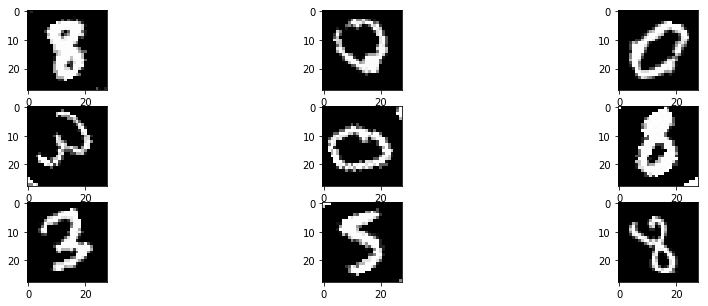

In [143]:
# data augmentation
# in case of images and labels we have to use the following approach: 
# create 2 instances with the same arguments: 
shift = 0.02
angle = 45
image_data_gen_args = dict(featurewise_center=False, 
                             featurewise_std_normalization=False, 
                             # zca_whitening=True, 
                             rotation_range=angle,
                             width_shift_range=shift, 
                             height_shift_range=shift,
                             fill_mode = 'wrap',
                             # cval = 0,
                             horizontal_flip=True, 
                             vertical_flip=True)

datagen = ImageDataGenerator(**image_data_gen_args)
# labelgen = ImageDataGenerator(**image_data_gen_args)

datagen.fit(x_train, augment=True, seed=seed)
# labelgen.fit(np_dataset_l_train, augment=True, seed=seed)

# image_generator = datagen.flow(
#     x_train,
#     seed=seed, 
#     batch_size = batch_size,
#     save_to_dir='data/aug', save_prefix='cell', save_format='png')
# label_generator = labelgen.flow(
#     np_dataset_l_train,
#     seed=seed,
#     batch_size = batch_size,
#     save_to_dir='data/aug', save_prefix='dots', save_format='png')

j_batch = 0
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    print(j_batch, "th batch with the shapes:", X_batch.shape, y_batch.shape)   
    
    # create a grid of 3x3 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
    # show the plot
    plt.show()
    break
    
    j_batch += 1;
    if (j_batch >= 10):
        break
    